In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import ode as ode
from matplotlib import pyplot as plt
#import xlsxwriter
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
#from model_vectorised_dg_extended import *
from ipynb.fs.full.model_vectorised_dg_extended import *
os.chdir(os.getcwd())

##### 1. Create 'data' folder in parent directory to save the simulation data there
##### 2. Create the two main subfolders: with internalisation/no internalisation -> all perturbations of the different processes are performed once with internalisation, once without internalisation
##### 3. Create sub-subfolders for the individual perturbed processess

In [2]:
if not os.path.exists('../data'):
    print('folder created: ../data')
    print()
    os.makedirs('../data')

for intern_dirname in ['With_internalisation','No_internalisation']:
    path=os.path.join('../data/',intern_dirname)
    if not os.path.exists(path):
        print('folder created: ',path)
        os.makedirs(path)
    print()

perturbed_processes=['Koff_Kon_all','Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM','Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
'Arrestin_association','Arrestin_dissociation','Internalisation']

for intern_dirname in ['With_internalisation','No_internalisation']:
    for process_dirname in perturbed_processes:
        path=os.path.join('../data/',intern_dirname,process_dirname,'')
        if intern_dirname=='No_internalisation' and process_dirname=='Internalisation':
            continue
        if not os.path.exists(path):
            print('folder created: ',path)
            os.makedirs(path)

folder created: ../data

folder created:  ../data/With_internalisation

folder created:  ../data/No_internalisation

folder created:  ../data/With_internalisation/Koff_Kon_all/
folder created:  ../data/With_internalisation/Phosphorylation_PM/
folder created:  ../data/With_internalisation/Phosphorylation_IC/
folder created:  ../data/With_internalisation/Phosphorylation_IC_PM/
folder created:  ../data/With_internalisation/Phosphatase_PM/
folder created:  ../data/With_internalisation/Phosphatase_IC/
folder created:  ../data/With_internalisation/Phosphatase_IC_PM/
folder created:  ../data/With_internalisation/Arrestin_association/
folder created:  ../data/With_internalisation/Arrestin_dissociation/
folder created:  ../data/With_internalisation/Internalisation/
folder created:  ../data/No_internalisation/Koff_Kon_all/
folder created:  ../data/No_internalisation/Phosphorylation_PM/
folder created:  ../data/No_internalisation/Phosphorylation_IC/
folder created:  ../data/No_internalisation/Pho

### Perturbation of Kon-Koff all 

In [12]:
## Dictionary holding the numbers of the molecules in the model (for explanation, look up model-figure.pdf)
molecules_dict={'Arrestin-Receptor':[10,11,12,13,14,15],
                'Ligand':[1,3],
                'Arrestin': [2],
                'Receptor':[4]}


### Dictionary holding the name of the perturbed processes and the number of perturbed processes that they 
##  are corresponding to in the model (i.e. Kon value of L + R -> LR is K value number 1,5,9,..., check out model-figure.pdf for visual
## explanation)

### In each perturbation round two sets of processes are perturbed:
##  1. Kon-Koff values of the Ligand-Receptor binding
##  2. Other cellular processes (i.e. internalisation, phosphorylation, etc...)
##  By looping this dictionary each 

## 1. "Koff_Kon_perturbations" hold the perturbed values (kon_values,koff_values) but also the number of the Kon-Koff values 
#  in the model (kon_model_numbers,koff_model_numbers)
## 2. "Process_model_numbers" hold the model numbers for the respective cellular process 


perturbed_processes={'Koff_Kon_all':{'Koff_Kon_perturbations':{ 'kon_values':[0.03,0.3,3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.03,0.3],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                     'Process_model_numbers':[]},

                    'Phosphorylation_PM':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.3],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'Process_model_numbers':[30]},

                    'Phosphorylation_IC':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.3],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'Process_model_numbers':[50]},

                    'Phosphorylation_IC_PM':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.3],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                            'Process_model_numbers':[50,30]},

                    'Phosphatase_PM':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.03,0.3],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                      'Process_model_numbers':[25,27,29]},

                    'Phosphatase_IC':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.03,0.3],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                      'Process_model_numbers': [47,48,49]},  

                    'Phosphatase_IC_PM':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.3],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'Process_model_numbers': [25,27,29,47,48,49]},

                    'Arrestin_association':{'Koff_Kon_perturbations':{  'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.3],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                            'Process_model_numbers': [35,44,36,37,45,46]},

                    'Arrestin_dissociation':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.3],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                             'Process_model_numbers': [32,33,41,42,34,43]},

                    'Internalisation':{'Koff_Kon_perturbations':{   'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.3],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'Process_model_numbers': [38, 39, 40]}}

                     
## Determine ligand concentrations              
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
internalisation_status=['With_internalisation','No_internalisation']

## Simulation time
simulation_time=1200

## List of perturbation factors, that are used for the perturbations of cellular processes ->
## Each rate constant (contained by 'Process_model_numbers')in the cellular process to be perturbed gets multiplied 
# by this factor to change the process' speed
factor_list=[100,30,10,3,1,0.3,0.1,0.03,0.01]

## Calculate the number of all models
num_of_all_simulations=0
for key in perturbed_processes.keys():
    kon_num=len(perturbed_processes[key]['Koff_Kon_perturbations']['kon_values'])
    koff_num=len(perturbed_processes[key]['Koff_Kon_perturbations']['koff_values'])
    if len(perturbed_processes[key]['Process_model_numbers'])>0:
        if key=='Internalisation':
            num_of_sim_in_perturbation=kon_num*koff_num*len(factor_list)*len(ligand_ccs)
        if key!='Internalisation':
            num_of_sim_in_perturbation=kon_num*koff_num*len(factor_list)*len(ligand_ccs)*len(internalisation_status)
    elif len(perturbed_processes[key]['Process_model_numbers'])==0:
        num_of_sim_in_perturbation=kon_num*koff_num*len(ligand_ccs)*len(internalisation_status)
    num_of_all_simulations=num_of_all_simulations + num_of_sim_in_perturbation



## Function for running the simulation for a given set of parameters
def simulation(intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,factor=None):
    ## Select the perturbed process out out of perturbed processes dictionary and initialise the Ko Koff values
    perturbed_process=perturbed_processes[process_name]
    kon_values=perturbed_process['Koff_Kon_perturbations']['kon_values']
    koff_values=perturbed_process['Koff_Kon_perturbations']['koff_values']
 
    ## Loop over Kon and Koff values
    for a,kon in enumerate(kon_values):
        for b,koff in enumerate(koff_values):
            ## Adjust ligand concentrations according to the changing Koff/Kon ratio (==Kd)-> changing ligand affinity needs changing
            # ligand concentrations to achieve same efficacy (if ligand affinity drops -> ligand concentration needs to 
            # achieve increase for same effect)
            Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
            ligands = ligand_ccs * Kd_ratio

            ## Directory path to save results to
            dirname=os.path.join('../data/',intern_status,process_name,'')

            ## Loop over all the used ligand concentrations
            for ligand in ligands:
                ## Initialise model, and change the necessary rate constants, ligand concentrations
                model = VecModel(0.1)
                model.read('../model/toth_szalai_modified.txt')
                model.change_constant(perturbed_process['Koff_Kon_perturbations']['kon_model_numbers'], kon)
                model.change_constant(perturbed_process['Koff_Kon_perturbations']['koff_model_numbers'], koff)
                model.change_ccs(molecules_dict['Ligand'], ligand)

                ## In case of no internalisation, set internalisation rate constant to 0
                if intern_status=='No_internalisation':
                    model.change_constant(perturbed_processes['Internalisation']['Process_model_numbers'], 0)
        
                ## If there is a cellular process to ber perturbed, multiply the rate constants of the process by the perturbation factor
                if factor !=None:
                    model.multiply_constant_with_factor(perturbed_process['Process_model_numbers'], factor)


                ## Simulate the process for one constellation of parameters
                model.simulate(simulation_time)

                ## Print number of simulations and elapsed/remaining time to check on status of the simulation
                sim_number=sim_number+1                
                elapsed_time=(time.time()-start_time)/3600
                remaining_time=((1/(sim_number/num_of_all_simulations))*elapsed_time-elapsed_time)
                print(round(100*sim_number/num_of_all_simulations,2),' % Done ','Elapsed time (h): ',round(elapsed_time,4),
                'Remaining time (h):',round(remaining_time,4),end="")
                print("\r", end="")     

                
                ## Convert concentrations of the molecules into a dataframe and save as csv
                ## Rows: time
                ## Columns: concentrations of molecules considered in the simulation
                if factor !=None:
                    fname=dirname+ '_'.join([process_name,str(factor),'koff',str(koff),'kon',str(kon),'ligand_cc',str(np.log10(ligand)-6)])+'.csv'
                elif factor==None:
                    fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(np.log10(ligand)-6)]) + '.csv'
                model.save_to_csv(fname)
      
    return(sim_number)


## Keep track of number of simulations and elapsed time
import time
sim_number=0
start_time = time.time()

## Loop over experimental settings and select parameters for the simulation
for intern_status in internalisation_status[:]:
    for process_name in perturbed_processes.keys():

        ## In the case of no internalisation don't run perturbation of Internalisation process, as internalisation is set to 0.
        if intern_status=='No_internalisation' and process_name=='Internalisation':
            continue
        
        ## If there is a cellular process to be perturbed, loop over the perturbation factors that will be used for rate constant perturbation
        if len(perturbed_processes[process_name]['Process_model_numbers'])>0:
            for factor in factor_list:
                sim_number=simulation(intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,factor=factor)
        
        ## If only Kon-Koff values are perturbed, don't loop over factors
        elif len(perturbed_processes[process_name]['Process_model_numbers'])==0:
            sim_number=simulation(intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,factor=None)

print()
print('Simulations done. Runtime (h): ',(time.time()-start_time)/3600)

Traceback (most recent call last):
  File "/Users/daniel.garger/Desktop/Projects/gpcr-signaling-simulation/code/model_vectorised_dg_extended.ipynb", line 109, in calculate_dydt
capi_return is NULL
Call-back cb_f_in_dvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    "            for j in range(len(r_to[i])):\n",
KeyboardInterrupt


: 

: 

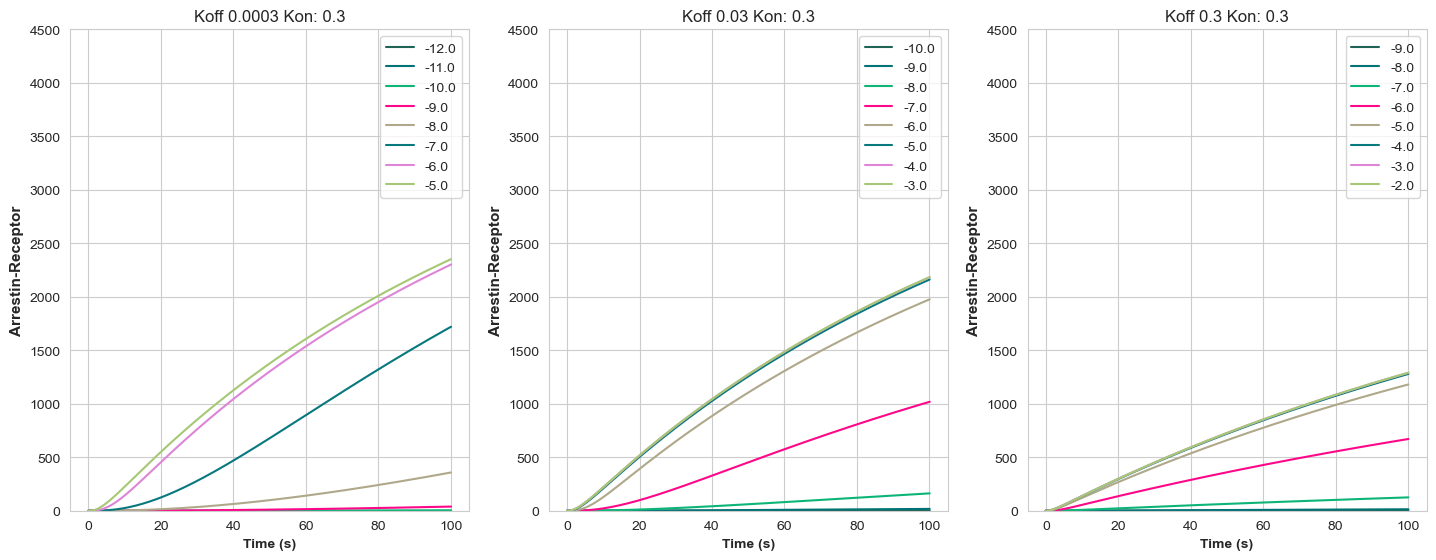

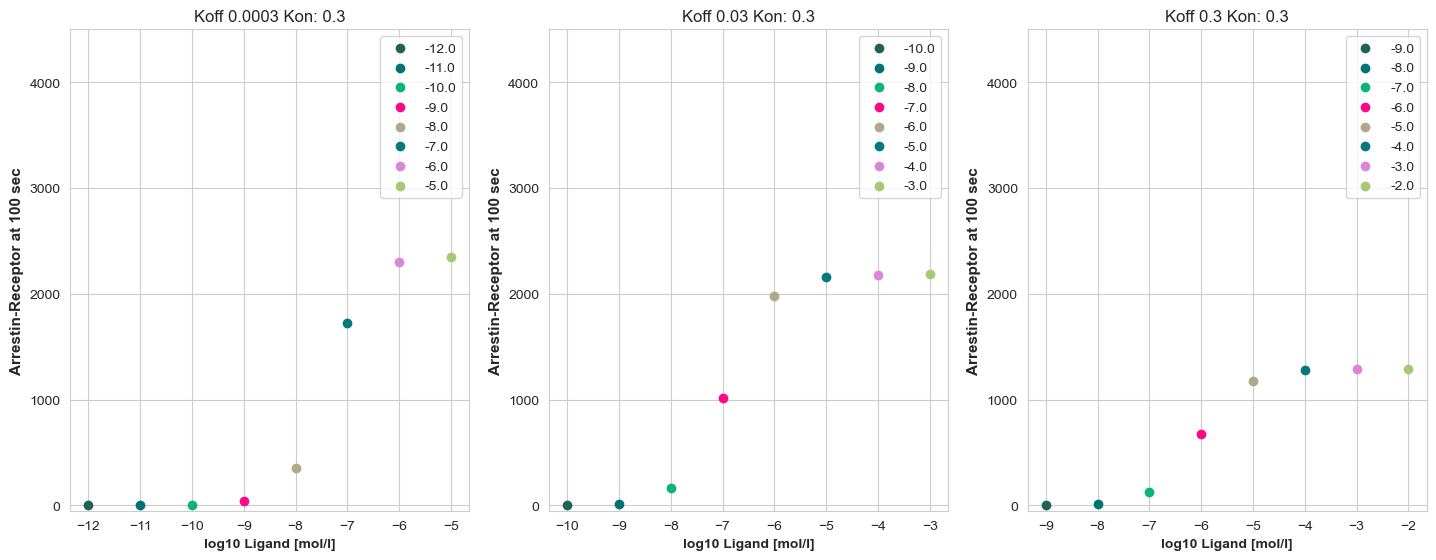

In [11]:
kon=0.3
process_name='Koff_Kon_all'
dirname='../data/With_internalisation/Koff_Kon_all/'
import matplotlib.colors as mcolors

fig,ax=plt.subplots(1,3,figsize=(17.5,6.25))
fig2,ax2=plt.subplots(1,3,figsize=(17.5,6.25))
for n,koff in enumerate([0.0003,0.03,0.3]):
    
    Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
    ligands = ligand_ccs * Kd_ratio
    ligands=(np.log10(ligands) - 6)
    colors=[*mcolors.XKCD_COLORS][25:25+len(ligands)]
    for ligand,color in zip(ligands,colors):
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
        col_nums=[int(x+1) for x in molecules_dict['Arrestin-Receptor']]
        col_nums.append(0)
        arr_receptor_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
        ax[n].plot(arr_receptor_df.index.tolist(),np.sum(arr_receptor_df.loc[:,:],1),label=ligand,color=mcolors.XKCD_COLORS[color])
        ax2[n].scatter(ligand,np.sum(arr_receptor_df.iloc[-1,:]),label=ligand,color=mcolors.XKCD_COLORS[color])
    ax[n].legend()
    title=' '.join(['Koff',str(koff),'Kon:',str(kon)])
    ax[n].set_title(title)
    ax[n].set_xlabel('Time (s)',fontweight="bold")
    ax[n].set_ylabel('Arrestin-Receptor',fontweight="bold",fontsize=11)
    ax[n].set_ylim(0,4500)
    ax2[n].legend(ligands)
    ax2[n].set_title(title)
    ax2[n].set_xlabel('log10 Ligand [mol/l]',fontweight="bold")
    ax2[n].set_ylabel('Arrestin-Receptor at '+str(int(arr_receptor_df.index.tolist()[-1])) +' sec',fontweight="bold",fontsize=11)
    ax2[n].set_ylim(-50,4500)
fig.savefig('../data/control_figs/plot2.png',dpi=300)
fig2.savefig('../data/control_figs/plot3.png',dpi=300)

In [6]:
fig,ax=plt.subplots(1,len(sim_time_dict.keys()),figsize=(17.5,6.25))
for n,key in enumerate(sim_time_dict.keys()):
    ax[n].scatter((sim_time_dict[key]['ligand_ccs']),sim_time_dict[key]['sim_times'])
    title=key.split('None_')[1]
    ax[n].set_title(title)
    ax[n].set_xlabel('log10 Ligand [mol/l]',fontweight="bold")
    ax[n].set_ylim(0,300)
    ax[n].set_ylabel('Duration of model simulation (sec)\n with given koff, kon, ligand cc.', fontweight="bold",fontsize=11)
fig.savefig('../data/control_figs/plot1.png',dpi=300)

NameError: name 'sim_time_dict' is not defined